# 3.5. Combine imágenes oscuras calibradas para usarlas en pasos de reducción posteriores 
El paso final es combinar las imágenes oscuras calibradas individuales en una sola imagen combinada. Esa imagen combinada tendrá menos ruido que las imágenes individuales, minimizando el ruido agregado a las imágenes restantes cuando se resta la oscuridad.

Independientemente de la ruta que tomó a través de la calibración de los sesgos (con overscan o sin), debe haber una carpeta llamada example1-reducedo example2-reducedque contenga el sesgo calibrado y las imágenes oscuras. Si no lo hay, ejecute el cuaderno anterior antes de continuar con este.

In [1]:
from pathlib import Path
import os

from astropy.nddata import CCDData
from astropy.stats import mad_std

import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np

from convenience_functions import show_image

In [2]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

# 3.5.1. Configuración recomendada para la combinación de imágenes 
Como se discutió en el cuaderno sobre la combinación de imágenes , la recomendación es que combine promediando las imágenes individuales pero con un recorte sigma para eliminar los valores extremos.

ccdproc proporciona dos formas de combinar:

Una interfaz orientada a objetos construida alrededor del Combinerobjeto, descrita en la documentación de ccdproc sobre la combinación de imágenes .

Una función llamada combine, que usaremos aquí porque la función le permite especificar la cantidad máxima de memoria que debe usarse durante la combinación. Esa característica puede ser esencial dependiendo de cuántas imágenes necesite combinar, qué tan grandes sean y cuánta memoria tenga su computadora.

NOTA: Si usa una versión de ccdproc anterior a la 2.0, establezca el límite de memoria en un factor de 2-3 por debajo de lo que desea que sea el consumo máximo de memoria.

# 3.5.2. Ejemplo 1: Cámara enfriada criogénicamente 
El resto de esta sección asume que las imágenes de polarización calibradas están en la carpeta example1-reducedque se creó en el cuaderno anterior.

In [3]:
calibrated_path = Path('example1-reduced')
reduced_images = ccdp.ImageFileCollection(calibrated_path)

# 3.5.2.1. Haga una imagen combinada para cada tiempo de exposición en el Ejemplo 1 
Hay varios tiempos de exposición oscuros en este conjunto de datos. Al convertir los tiempos en la tabla de resumen en un conjunto, solo devuelve los valores únicos.

In [4]:
darks = reduced_images.summary['imagetyp'] == 'DARK'
dark_times = set(reduced_images.summary['exptime'][darks])
print(dark_times)

{300.0, 70.0, 7.0}


El siguiente código recorre los tiempos de exposición oscuros y, para cada tiempo de exposición:

    selecciona las imágenes oscuras calibradas relevantes,

    los combina usando la combinefunción,

    agrega la palabra clave COMBINEDal encabezado para que los pasos de calibración posteriores puedan identificar fácilmente qué sesgo usar, y

    escribe el archivo cuyo nombre incluye el tiempo de exposición.

In [6]:
for exp_time in sorted(dark_times):
    calibrated_darks = reduced_images.files_filtered(imagetyp='dark', exptime=exp_time,
                                                     include_path=True)

    combined_dark = ccdp.combine(calibrated_darks,
                                 method='average',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                                 mem_limit=350e6
                                )

    combined_dark.meta['combined'] = True

    dark_file_name = 'combined_dark_{:6.3f}.fit'.format(exp_time)
    combined_dark.write(calibrated_path / dark_file_name)

INFO:astropy:splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


INFO:astropy:splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


INFO:astropy:splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


# 3.5.2.2. Resultado del Ejemplo 1 
A continuación se muestra una sola imagen oscura calibrada de 300 segundos y la imagen combinada de 300 segundos.

Text(0.5, 1.0, '3 dark images combined')

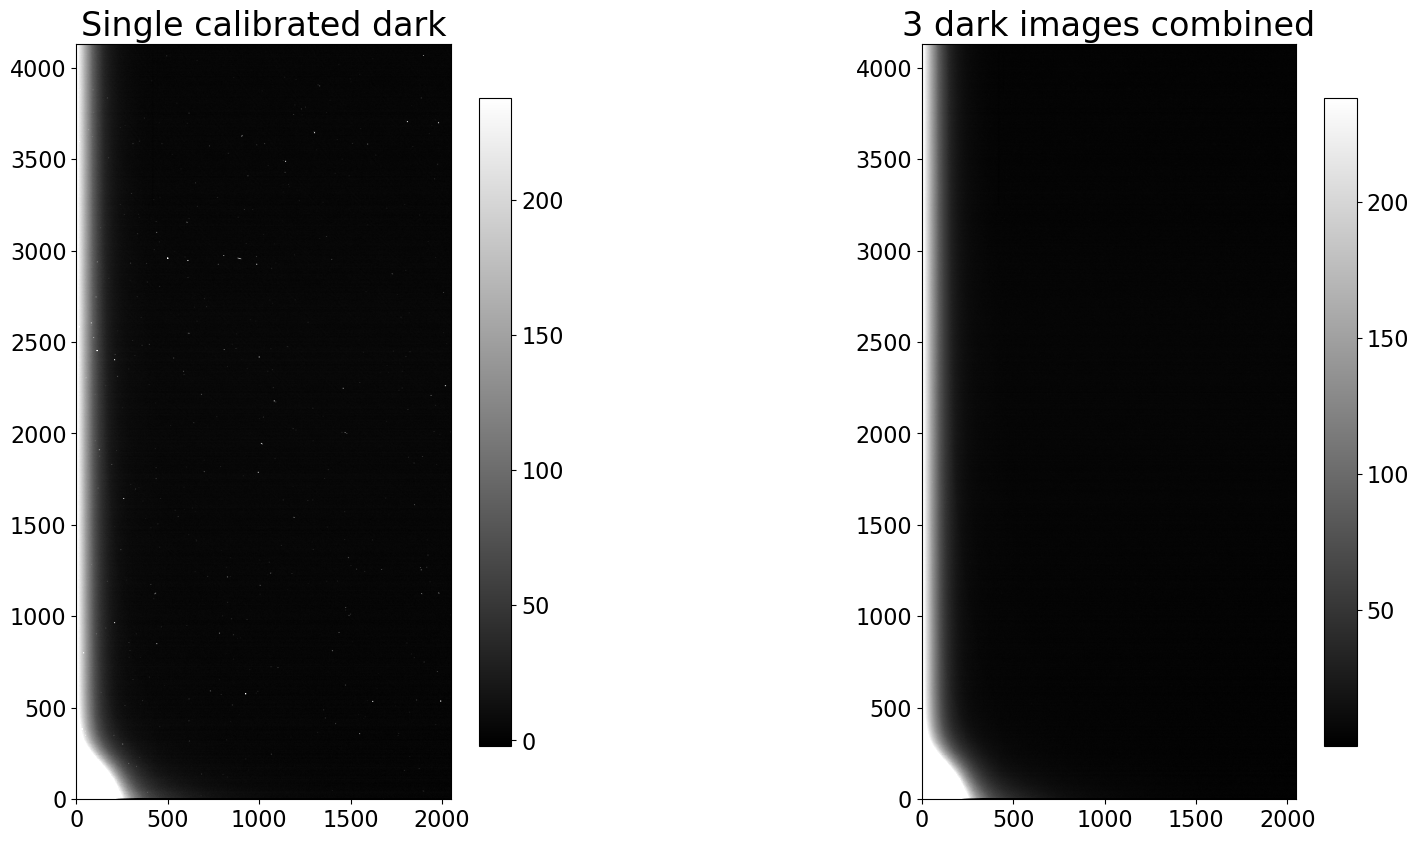

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

show_image(CCDData.read(calibrated_darks[0]).data, cmap='gray', ax=ax1, fig=fig)
ax1.set_title('Single calibrated dark')
show_image(combined_dark.data, cmap='gray', ax=ax2, fig=fig)
ax2.set_title('{} dark images combined'.format(len(calibrated_darks)))

# 3.5.3. Ejemplo 2: Cámara con refrigeración termoeléctrica 
El proceso para combinar las imágenes es exactamente el mismo que en el ejemplo 1. La única diferencia es el directorio que contiene los cuadros de polarización calibrados.

In [9]:
calibrated_path = Path('example2-reduced')
reduced_images = ccdp.ImageFileCollection(calibrated_path)

# 3.5.3.1. Haga una imagen combinada para cada tiempo de exposición en el Ejemplo 2 
En este ejemplo solo hay oscuros de un solo tiempo de exposición.

In [10]:
darks = reduced_images.summary['imagetyp'] == 'DARK'
dark_times = set(reduced_images.summary['exptime'][darks])
print(dark_times)

{90.0}


In [11]:
for exp_time in sorted(dark_times):
    calibrated_darks = reduced_images.files_filtered(imagetyp='dark', exptime=exp_time,
                                                     include_path=True)

    combined_dark = ccdp.combine(calibrated_darks,
                                 method='average',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                                 mem_limit=350e6
                                )

    combined_dark.meta['combined'] = True

    dark_file_name = 'combined_dark_{:6.3f}.fit'.format(exp_time)
    combined_dark.write(calibrated_path / dark_file_name)

INFO:astropy:splitting each image into 22 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 22 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


# 3.5.3.2. Resultado del Ejemplo 2 
La diferencia entre una sola imagen de sesgo calibrada y la imagen de sesgo combinado es mucho más clara en este caso.

Text(0.5, 1.0, '10 dark images combined')

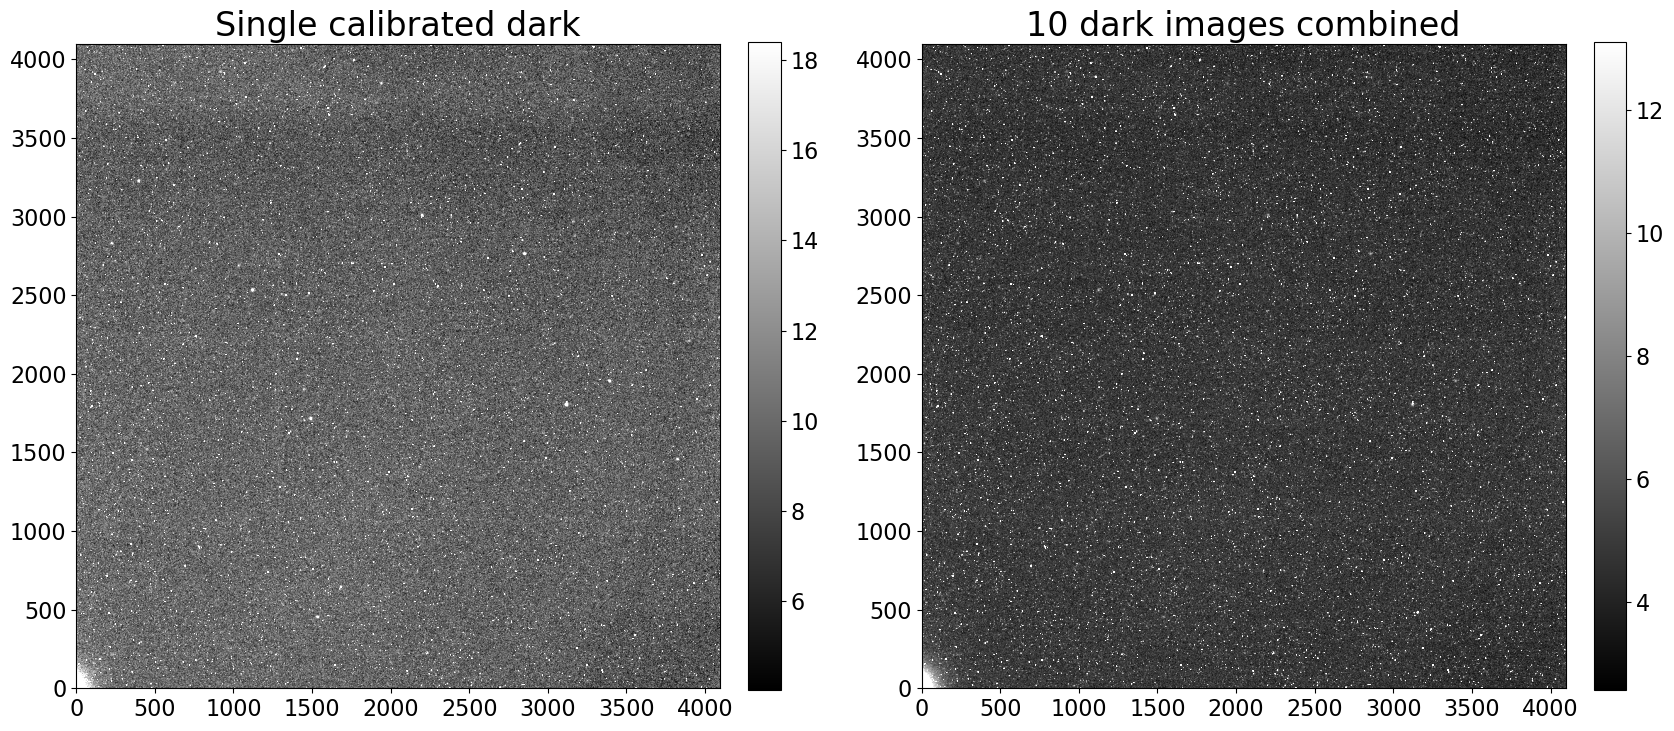

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

show_image(CCDData.read(calibrated_darks[0]).data, cmap='gray', ax=ax1, fig=fig)
ax1.set_title('Single calibrated dark')
show_image(combined_dark.data, cmap='gray', ax=ax2, fig=fig)
ax2.set_title('{} dark images combined'.format(len(calibrated_darks)))